In [1]:
# Env
import os
from dotenv import load_dotenv
if not load_dotenv() or 'HOPSWORKS_API_KEY' not in os.environ:
    print("Please provide a .env file add HOPSWORKS_API_KEY to it.")
    exit(1)

# No warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

# Imports
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
import hopsworks
import pandas as pd
import numpy as np
import math

# Heavy operation cache
from IPython.display import Image
from pathlib import Path
dir_plot_saves = "./plots"
# - Plots
Path(dir_plot_saves).mkdir(parents=True, exist_ok=True)
# Plot cache
def plot_or_cache(plotting_function, plot_name):
    plot_destination = f"{dir_plot_saves}/{plot_name}.png"
    if os.path.isfile(plot_destination):
        display(Image(filename=plot_destination))
    else:
        plotting_function()
        plt.savefig(plot_destination)
        plt.show()

# My help commands
from wine_training_help import evaluate_pca, train_evaluation

# 
import json
from hsfs.client.exceptions import RestAPIError

# IDE help
from hsfs import feature_store, feature_group, feature_view
from hsfs.constructor import query as hsfs_query

# Names
# - Models
model_red_wine_name = "wine_red_model"
model_red_wine_version = 1
model_white_wine_name = "wine_white_model"
model_white_wine_version = 1
# - Feature Groups
fg_wine_name = "wine"
fg_wine_version = 1
# fg_red_wine_name = "wine_red"
# fg_red_wine_version = 1
# fg_white_wine_name = "wine_white"
# fg_white_wine_version = 1
fg_type_red = "red"
fg_type_white = "white"

In [2]:
# Log in to Hopsworks and get feature store
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/201877
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
try:
    wine_fg: feature_group.FeatureGroup = fs.get_feature_group(name=fg_wine_name, version=fg_wine_version)
    print(f"Wine data (version: {fg_wine_version}) gotten!")
except RestAPIError as e:
    try:
        response_json = json.loads(e.response.content)
    except Exception:
        response_json = []
    
    if "errorMsg" in response_json and response_json["errorMsg"] == "Featuregroup wasn\'t found.":
        print(f"Wine (version: {fg_wine_version}) does not exist on Hopsworks. (upload it first)")
        
    else:
        raise Exception(f"An unexpected RestAPIError happened: {e.response.content}")
except Exception as e:
    raise Exception(f"Something unexpected happened: {e}")

Wine data (version: 1) gotten!


In [4]:
wine_query: hsfs_query.Query = wine_fg.select_all()
wine_query

In [5]:
wine_df: pd.DataFrame = wine_query.read()
wine_red_df = wine_df[wine_df["type"] == fg_type_red]
wine_red_df = wine_red_df.drop(columns=["type"])
wine_red_df

Finished: Reading data from Hopsworks, using ArrowFlight (1.21s) 


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
2,8.8,0.37,0.48,2.1,0.097,39.0,145.0,0.99750,3.04,1.03,9.3,5
9,8.8,0.59,0.18,2.9,0.089,12.0,74.0,0.99738,3.14,0.54,9.4,5
10,6.8,0.64,0.03,2.3,0.075,14.0,31.0,0.99545,3.36,0.58,10.4,6
19,6.3,0.68,0.01,3.7,0.103,32.0,54.0,0.99586,3.51,0.66,11.3,6
21,6.9,0.49,0.19,1.7,0.079,13.0,26.0,0.99547,3.38,0.64,9.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...
5293,12.5,0.56,0.49,2.4,0.064,5.0,27.0,0.99990,3.08,0.87,10.9,5
5299,9.1,0.30,0.41,2.0,0.068,10.0,24.0,0.99523,3.27,0.85,11.7,7
5304,11.7,0.45,0.63,2.2,0.073,7.0,23.0,0.99974,3.21,0.69,10.9,6
5305,8.1,0.72,0.09,2.8,0.084,18.0,49.0,0.99940,3.43,0.72,11.1,6


# PCA

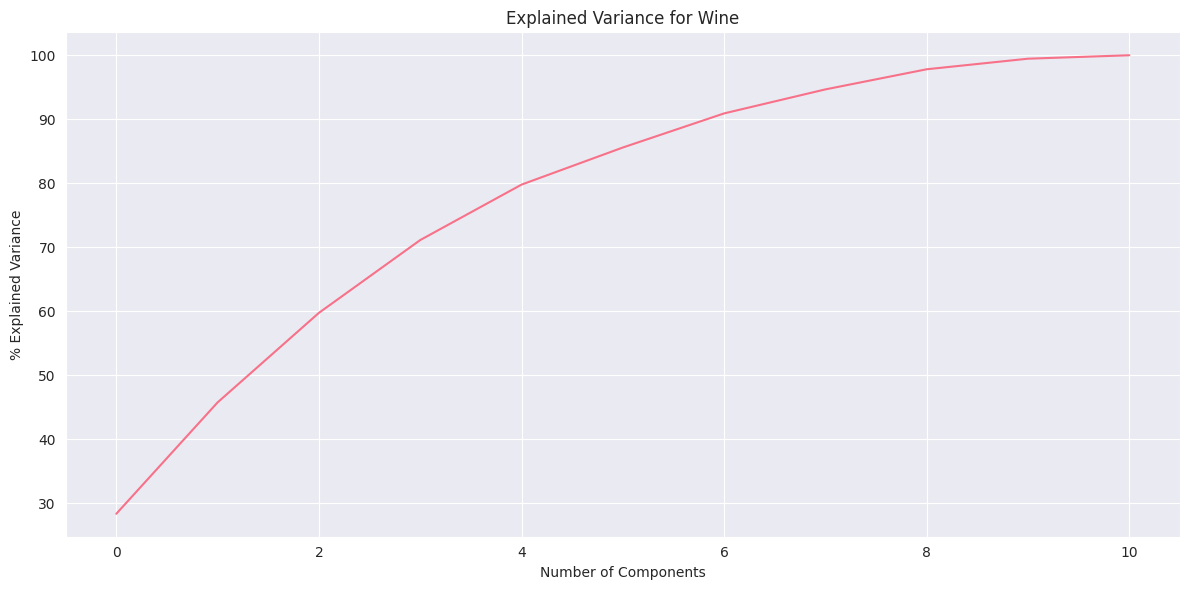

In [6]:
evaluate_pca(wine_red_df)

https://scribe.rip/@sanchitamangale12/scree-plot-733ed72c8608

If we should keep at least 80% of the total variance in the original dataset. Then it seems good to try 3-5 components for the red wine data.


In [7]:
# Try to look for best n_neighbors using cross validation
train_evaluation(wine_red_df, 'quality', use_model="KNeighborsClassifier")

No 'n_neighbors' set. Looking for best value...
Optimal number of neighbors: 9


9

In [8]:
# A KNN model with 25 neighbors might rarely predict the minority classes (3 and 8) correctly.

In [9]:
def brute_force_check_KNeighborsClassifier():
    df_acc = pd.DataFrame(columns=['PCA','n_neighbors','Resample','Accuracy'])
    
    for i in [False] + list(range(5, 8)):
        for j in list(range(1, 9, 2)) + list(range(19, 35, 2)):
            for k in [False, "undersample", "oversample", "smote"]:
                cur_accuracy = train_evaluation(
                    wine_red_df, 'quality', use_model="KNeighborsClassifier", 
                    use_pca_n_components=i,
                    use_resampler=k, class_knn_n_neighbors=j,
                    silent=True)
                print(f"Checked: PCA {i}, n_neighbors {j}, resample {k} -> {cur_accuracy}%")
                
                df_acc.loc[len(df_acc.index)] = [i, j, k, cur_accuracy]

    display(df_acc.sort_values(by='Accuracy', ascending=False))
    
brute_force_check_KNeighborsClassifier()

Checked: PCA False, n_neighbors 1, resample False -> 0.5625%
Checked: PCA False, n_neighbors 1, resample undersample -> 0.2977941176470588%
Checked: PCA False, n_neighbors 1, resample oversample -> 0.5441176470588235%
Checked: PCA False, n_neighbors 1, resample smote -> 0.4963235294117647%
Checked: PCA False, n_neighbors 3, resample False -> 0.5147058823529411%
Checked: PCA False, n_neighbors 3, resample undersample -> 0.28308823529411764%
Checked: PCA False, n_neighbors 3, resample oversample -> 0.5073529411764706%
Checked: PCA False, n_neighbors 3, resample smote -> 0.45955882352941174%
Checked: PCA False, n_neighbors 5, resample False -> 0.4963235294117647%
Checked: PCA False, n_neighbors 5, resample undersample -> 0.3088235294117647%
Checked: PCA False, n_neighbors 5, resample oversample -> 0.48161764705882354%
Checked: PCA False, n_neighbors 5, resample smote -> 0.40441176470588236%
Checked: PCA False, n_neighbors 7, resample False -> 0.5183823529411765%
Checked: PCA False, n_neig

,PCA,n_neighbors,Resample,Accuracy
176,7,27,False,0.580882
180,7,29,False,0.573529
88,5,31,False,0.566176
0,0,1,False,0.562500
32,0,27,False,0.562500
...,...,...,...,...
137,6,31,undersample,0.176471
189,7,33,undersample,0.154412
141,6,33,undersample,0.150735
45,0,33,undersample,0.143382


In [10]:
# Inspect #1 result with 54%

n_neighbors=27
Accuracy: 58.09%


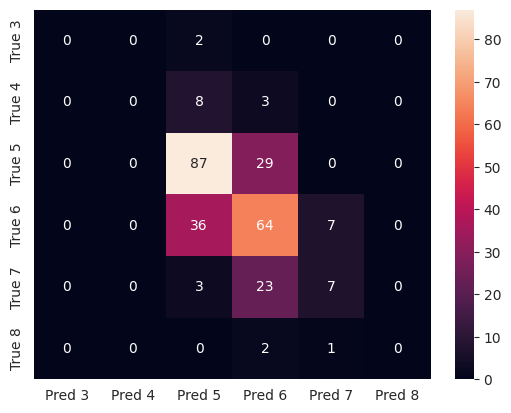




n_neighbors=29
Accuracy: 57.35%


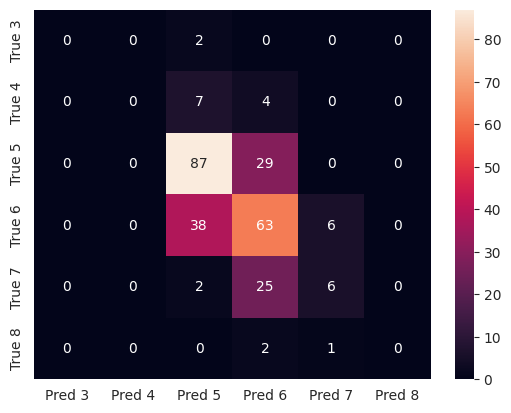




n_neighbors=31
Accuracy: 54.41%


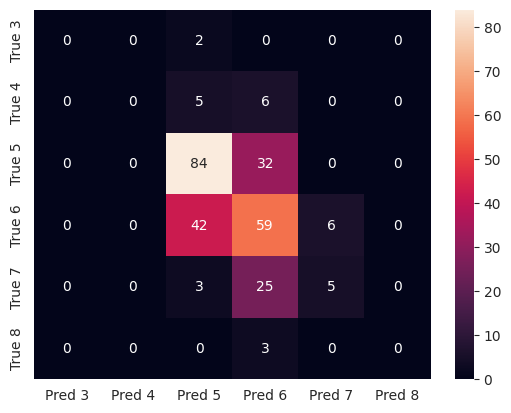

In [11]:
for i in range(27, 32, 2):
    print(f"n_neighbors={i}")
    accuracy, df_cm = train_evaluation(
        wine_red_df, 'quality', use_model="KNeighborsClassifier", 
        use_pca_n_components=7,
        use_resampler=False, 
        class_knn_n_neighbors=i)
    plt.figure()
    cm = sns.heatmap(df_cm, annot=True)
    cm.get_figure()
    plt.show()
    print("\n\n")

In [12]:
# Inspect #2 result with 54%

n_neighbors=17
Accuracy: 55.51%


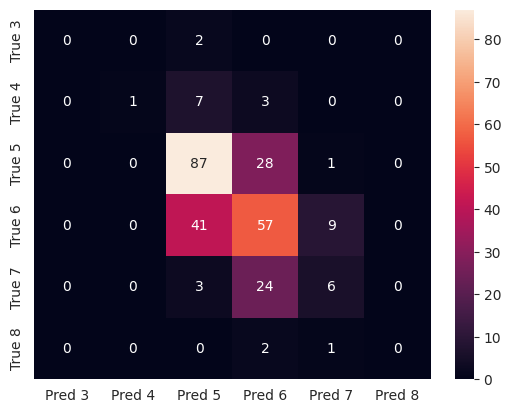




n_neighbors=19
Accuracy: 53.68%


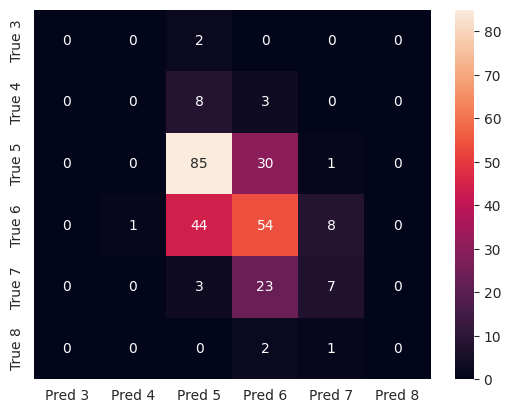




n_neighbors=21
Accuracy: 53.31%


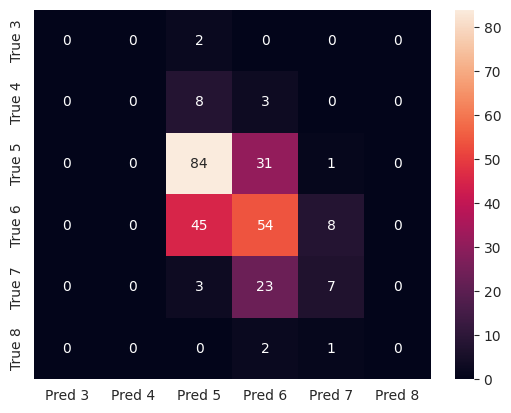

In [13]:
for i in range(17, 22, 2):
    print(f"n_neighbors={i}")
    accuracy, df_cm = train_evaluation(
        wine_red_df, 'quality', use_model="KNeighborsClassifier", 
        use_pca_n_components=5,
        use_resampler=False, 
        class_knn_n_neighbors=i)
    plt.figure()
    cm = sns.heatmap(df_cm, annot=True)
    cm.get_figure()
    plt.show()
    print("\n\n")

In [14]:
# Inspect #3 result with 53%

n_neighbors=29
Accuracy: 57.35%


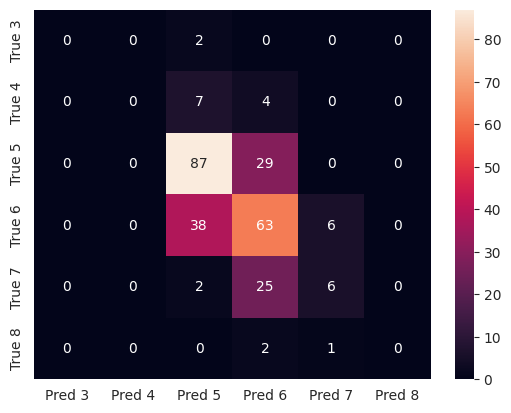




n_neighbors=31
Accuracy: 54.41%


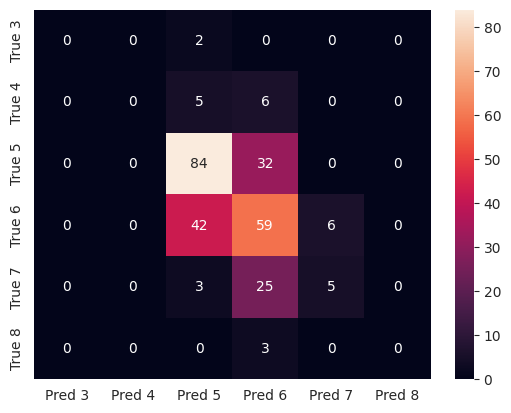




n_neighbors=33
Accuracy: 55.15%


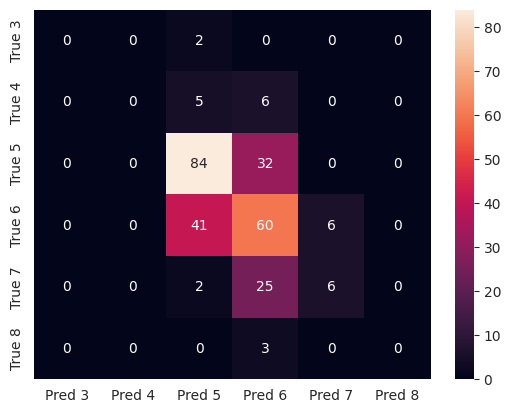

In [15]:
for i in range(29, 34, 2):
    print(f"n_neighbors={i}")
    accuracy, df_cm = train_evaluation(
        wine_red_df, 'quality', use_model="KNeighborsClassifier", 
        use_pca_n_components=7,
        use_resampler=False, 
        class_knn_n_neighbors=i)
    plt.figure()
    cm = sns.heatmap(df_cm, annot=True)
    cm.get_figure()
    plt.show()
    print("\n\n")

In [16]:
# Adjusting categories
# It is probably not allowed, but as there are so few high or low ranking wines, 
# it may be difficult to train a model on this data. If the categories are adjusted to: 
# low, medium and high quality wines (just 3 categories), the model might perform better. 
# There are a lot of wines in the 5-6 range. So the categories can be:
# - Low: 0-5
# - Medium: 5-6
# - High: 6-10

In [17]:
# Try to look for best n_neighbors using cross validation
train_evaluation(
    wine_red_df, 'quality', use_model="KNeighborsClassifier",
    classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']))

No 'n_neighbors' set. Looking for best value...
Optimal number of neighbors: 17


17

In [18]:
def brute_force_check_KNeighborsClassifier_adjust():
    df_acc = pd.DataFrame(columns=['PCA','n_neighbors','Resample','Accuracy'])
    
    for i in [False] + list(range(5, 8)):
        for j in list(range(1, 9 + 1, 2)) + list(range(29 - 4, 29 + 4 + 1, 2)):
            for k in [False, "undersample", "oversample", "smote"]:
                cur_accuracy = train_evaluation(
                    wine_red_df, 'quality', use_model="KNeighborsClassifier", 
                    classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']),
                    use_pca_n_components=i,
                    use_resampler=k, class_knn_n_neighbors=j,
                    silent=True)
                print(f"Checked: PCA {i}, n_neighbors {j}, resample {k} -> {cur_accuracy}%")
                
                df_acc.loc[len(df_acc.index)] = [i, j, k, cur_accuracy]

    display(df_acc.sort_values(by='Accuracy', ascending=False))
    
brute_force_check_KNeighborsClassifier_adjust()

Checked: PCA False, n_neighbors 1, resample False -> 0.6139705882352942%
Checked: PCA False, n_neighbors 1, resample undersample -> 0.5147058823529411%
Checked: PCA False, n_neighbors 1, resample oversample -> 0.6066176470588235%
Checked: PCA False, n_neighbors 1, resample smote -> 0.6176470588235294%
Checked: PCA False, n_neighbors 3, resample False -> 0.5735294117647058%
Checked: PCA False, n_neighbors 3, resample undersample -> 0.5036764705882353%
Checked: PCA False, n_neighbors 3, resample oversample -> 0.5772058823529411%
Checked: PCA False, n_neighbors 3, resample smote -> 0.6066176470588235%
Checked: PCA False, n_neighbors 5, resample False -> 0.5441176470588235%
Checked: PCA False, n_neighbors 5, resample undersample -> 0.5514705882352942%
Checked: PCA False, n_neighbors 5, resample oversample -> 0.5514705882352942%
Checked: PCA False, n_neighbors 5, resample smote -> 0.5514705882352942%
Checked: PCA False, n_neighbors 7, resample False -> 0.5551470588235294%
Checked: PCA False

,PCA,n_neighbors,Resample,Accuracy
3,0,1,smote,0.617647
0,0,1,False,0.613971
2,0,1,oversample,0.606618
75,5,31,smote,0.606618
7,0,3,smote,0.606618
...,...,...,...,...
87,6,3,smote,0.511029
86,6,3,oversample,0.503676
5,0,3,undersample,0.503676
81,6,1,undersample,0.503676


In [19]:
# Inspect #1 result with 58%

n_neighbors=29
Accuracy: 57.35%


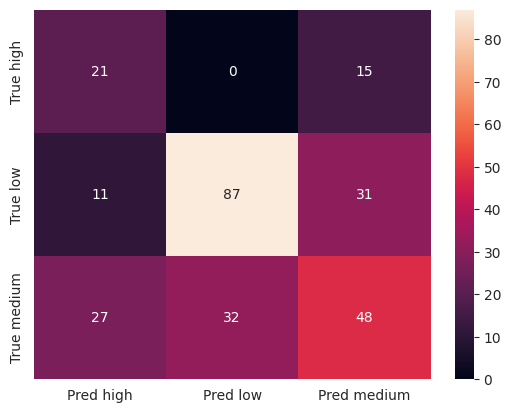




n_neighbors=31
Accuracy: 57.72%


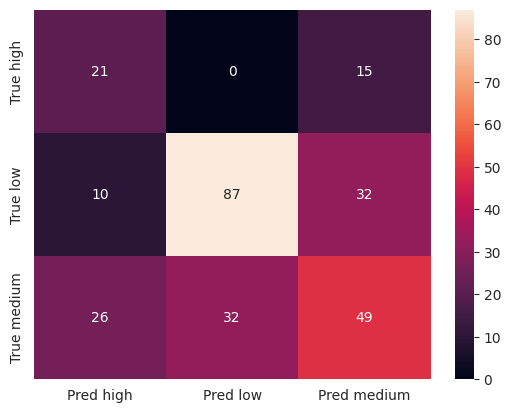




n_neighbors=33
Accuracy: 57.35%


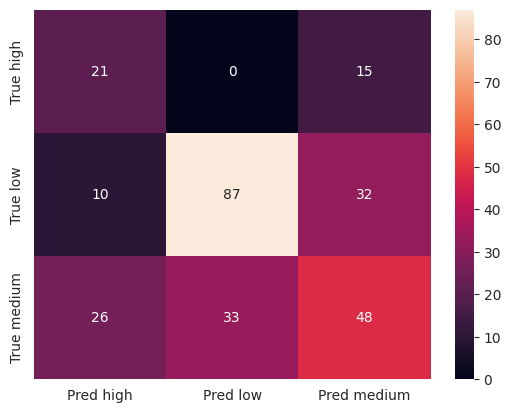

In [20]:
for i in range(29, 34, 2):
    print(f"n_neighbors={i}")
    accuracy, df_cm = train_evaluation(
        wine_red_df, 'quality', use_model="KNeighborsClassifier", 
        classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']),
        use_pca_n_components=5,
        use_resampler="oversample", 
        class_knn_n_neighbors=i)
    plt.figure()
    cm = sns.heatmap(df_cm, annot=True)
    cm.get_figure()
    plt.show()
    print("\n\n")

In [21]:
# Inspect #2 result with 58%

n_neighbors=3
Accuracy: 57.35%


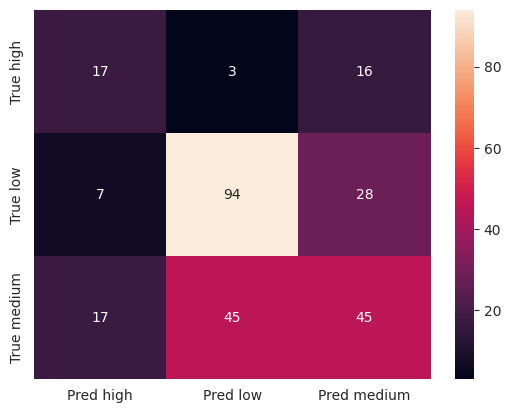




n_neighbors=5
Accuracy: 54.41%


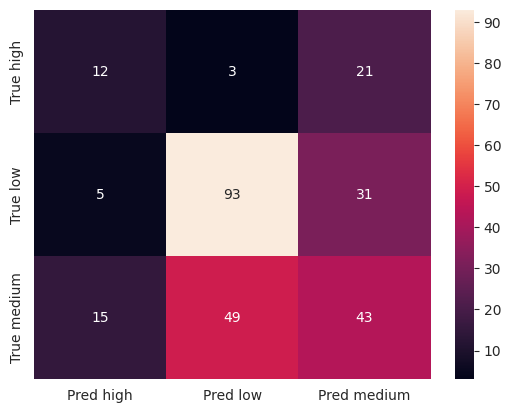




n_neighbors=7
Accuracy: 52.94%


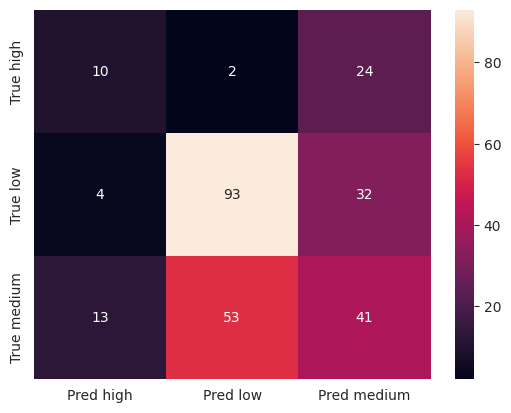

In [22]:
for i in range(3, 8, 2):
    print(f"n_neighbors={i}")
    accuracy, df_cm = train_evaluation(
        wine_red_df, 'quality', use_model="KNeighborsClassifier", 
        classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']),
        use_pca_n_components=5,
        use_resampler=False, 
        class_knn_n_neighbors=i)
    plt.figure()
    cm = sns.heatmap(df_cm, annot=True)
    cm.get_figure()
    plt.show()
    print("\n\n")

In [23]:
# Inspect #3 result with 57%

n_neighbors=29
Accuracy: 59.56%


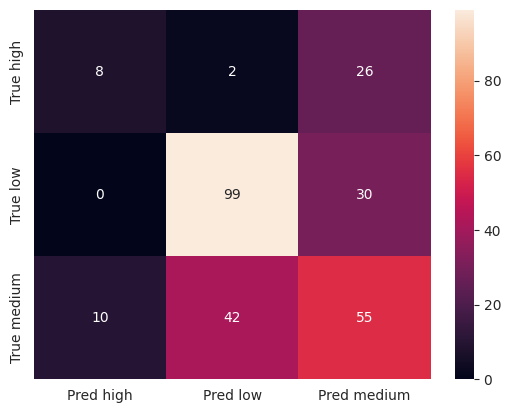




n_neighbors=31
Accuracy: 57.72%


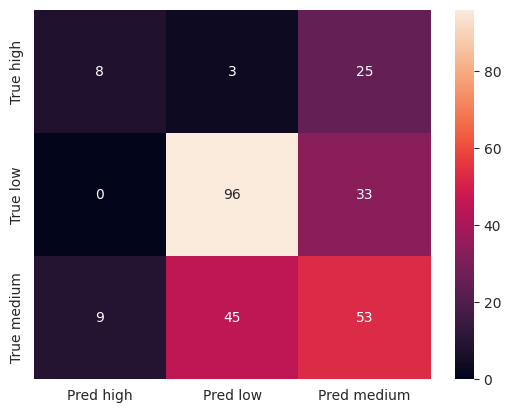




n_neighbors=33
Accuracy: 56.99%


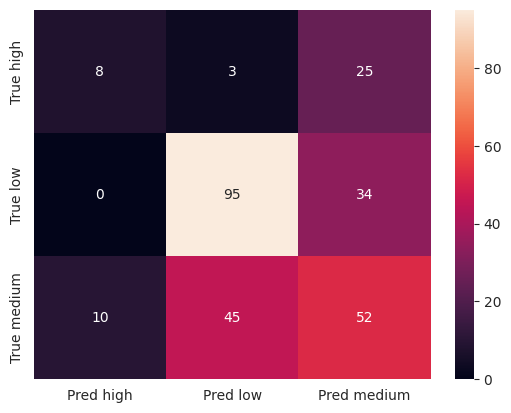

In [24]:
for i in range(29, 34, 2):
    print(f"n_neighbors={i}")
    accuracy, df_cm = train_evaluation(
        wine_red_df, 'quality', use_model="KNeighborsClassifier", 
        classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']),
        use_pca_n_components=7,
        use_resampler=False, 
        class_knn_n_neighbors=i)
    plt.figure()
    cm = sns.heatmap(df_cm, annot=True)
    cm.get_figure()
    plt.show()
    print("\n\n")